# Predicción

Este notebook se divide en tres partes, la creaccion del dataset de prediccion, la prediccion y el post-procesamiento

## 3°  Creación de dataset prediccion

Instalacion de pysatproc 

In [ ]:
# version que esta en python 
!pip install unetseg

# version de git
#!pip install -U git+https://github.com/dymaxionlabs/satproc.git@dab1cdbef0ef3a83c9e100952d9632e17bb18619

**Variables para configuracion de satproc**

In [1]:
path_to_files = "../images-S2/zona_5/2021-01-01_2021-03-01/*.tif"             # ruta a las imagenes satelitales
output_folder = "../dataset/data_predict/zona_5/v2/160_80/"                   # ruta donde se van a dejar las imagenes porcesadas
vector_aoi_file_path = "../data/shp/predict_aoi_zona5_buff5km_4326.geojson"   # archivo geojson con el area de interes                       
size = 160                                                                    # stamaño (pixeles) de las imagenes que se van a generar
step_size = size                                                              # tamaño de la ventana

**Generación del dataset para predecir**

In [ ]:
#Creo dataset para prediccion (solo imagenes)
!satproc_extract_chips $path_to_files \
    -o $output_folder \
    --aoi $vector_aoi_file_path \
    --size $size \
    --step-size $step_size \
    --rescale \
    --rescale-mode s2_rgb_extra --lower-cut 1 --upper-cut 100


## 4° Predicción

Para efectuar la predicción importamos las funciones necesarias de la libreria *unetseg*

In [2]:
from unetseg.predict import PredictConfig, predict
from unetseg.evaluate import plot_data_results
import os

**Variables para configuracion de la predicción**

In [3]:
zona='zona_5'
version = 'v2'
size_stepsize='160_80'

model = '../data/weights/model/zona_3UNet_techo_4D_spe100_img160_size160_sz80.h5'  #  ruta al modelo (.h5)
                                    

predict_config = PredictConfig(
                                    images_path = os.path.join('../dataset/data_predict',zona,version,size_stepsize),
                                    results_path = os.path.join('../dataset/data_results',zona,version,size_stepsize),
                                    batch_size=16,
                                    model_path= model,
                                    height=160,
                                    width=160,
                                    n_channels=4,
                                    n_classes=1,
                                    class_weights=[1])

Ejecuta la predicción

In [ ]:
predict(predict_config)

## 5° Post-procesamiento

El objetivo de esta etapa es filtrar los resultados para quedarnos con las predicciones más precisas y filtrar aquellas ruidosas 

In [4]:
from satproc.postprocess.polygonize import polygonize 
from satproc.filter import filter_by_max_prob

### Filtramos las predicciones con probabilidad mayor al parametro y poligonos mayor a una superficie determinada

In [ ]:
parametro_prob = 0.9 # parametro a filtrar
min_area = 500       # superficie minima a fitrar

#creamos una carpeta
carpeta = os.path.join('../dataset/data_results',zona,version,size_stepsize)+'_filtered_up'+str(parametro_prob).split('.')[0]+str(parametro_prob).split('.')[1]+'/'
!mkdir -p $carpeta

filter_by_max_prob(input_dir = os.path.join('../dataset/data_results',zona,version,size_stepsize),
                   output_dir = os.path.join('../dataset/data_results',zona,version,size_stepsize)+'_filtered_up'+str(parametro_prob).split('.')[0]+str(parametro_prob).split('.')[1]+'/',
                   threshold = parametro_prob) #Probar ≠ prob umbrales, por ahi, empezar con 0.1



input_path =  os.path.join('../dataset/data_results',zona,version,size_stepsize)+'_filtered_up'+str(parametro_prob).split('.')[0]+str(parametro_prob).split('.')[1]+'/'
output_path = os.path.join('../dataset/data_results',zona,version+'_'+size_stepsize+'_'+zona+'_thr_'+str(parametro_prob).split('.')[0]+str(parametro_prob).split('.')[1]+'.gpkg')


polygonize(threshold=parametro_prob,
          # value=100,
           input_dir=input_path,
           output=output_path)


src_file = os.path.join('../dataset/data_results',zona,version+'_'+size_stepsize+'_'+zona+'_thr_'+str(parametro_prob).split('.')[0]+str(parametro_prob).split('.')[1]+'.gpkg')

dst_file = os.path.join('../dataset/data_results',zona,version+'_'+size_stepsize+'_'+zona+'_thr_'+str(parametro_prob).split('.')[0]+str(parametro_prob).split('.')[1]+'_utm.gpkg')


!ogr2ogr -s_srs EPSG:4326 -t_srs EPSG:32720 -f 'ESRI Shapefile' $dst_file $src_file #lo puedo abrir en QGIS como archivo vectorial
        
        

input_path = os.path.join('../dataset/data_results',zona,version+'_'+size_stepsize+'_'+zona+'_thr_'+str(parametro_prob).split('.')[0]+str(parametro_prob).split('.')[1]+'_utm.gpkg')
output_path = input_path.replace(".gpkg", "_up"+str(min_area)+".gpkg")    
tabla = input_path.split("/",-1)[-1].strip('.gpkg').strip('_utm')
sql = "SELECT * FROM "+tabla+" m WHERE ST_Area(geometry) > "+str(min_area)        

!ogr2ogr -t_srs EPSG:32720 -f "GPKG" -sql "$sql" -dialect SQLITE -nln results $output_path $input_path

print('Archivo generado correctamente',output_path)

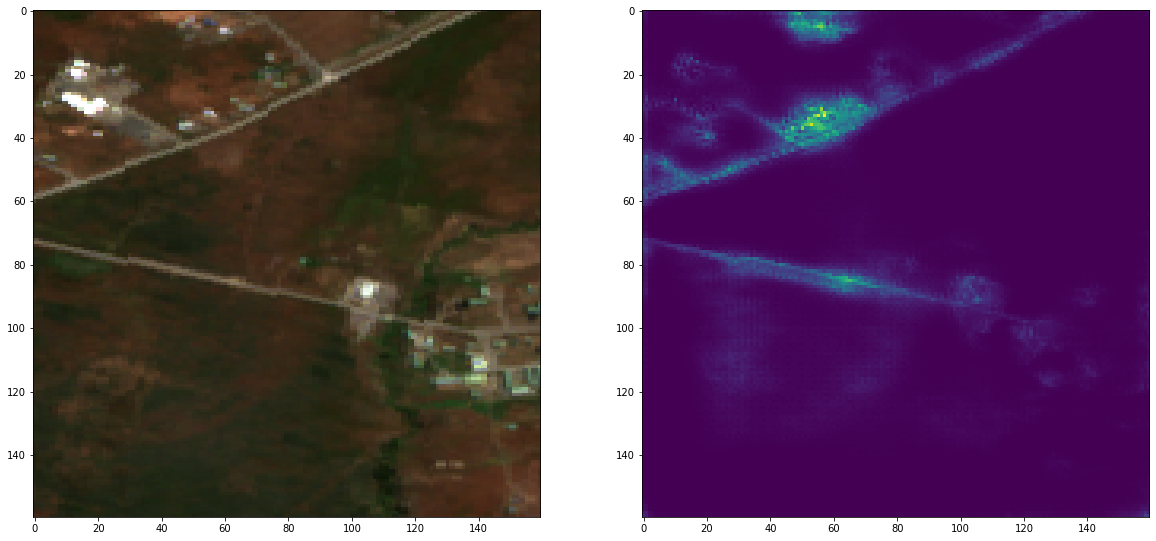

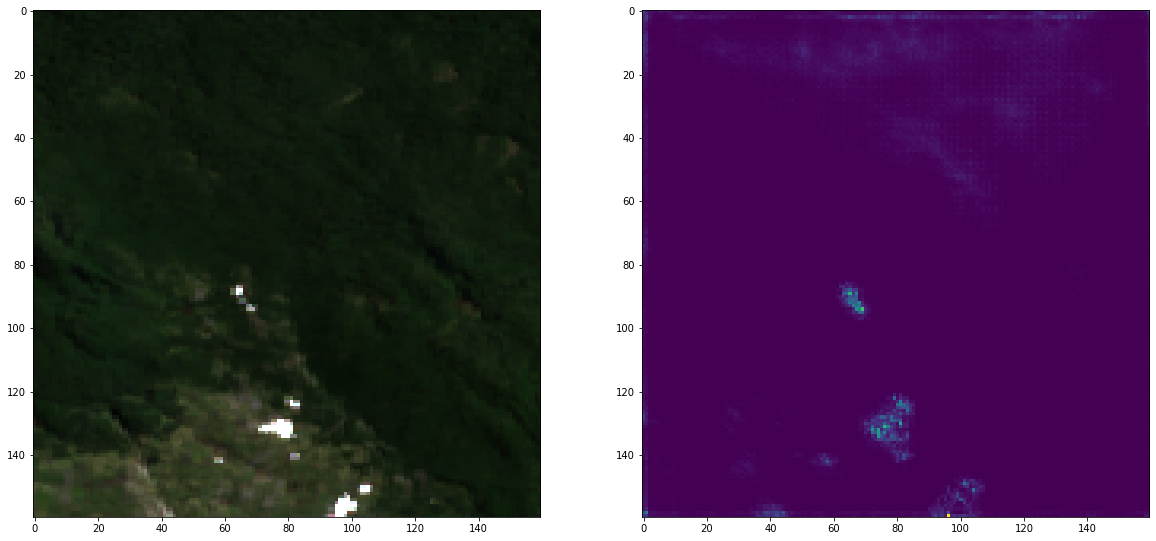

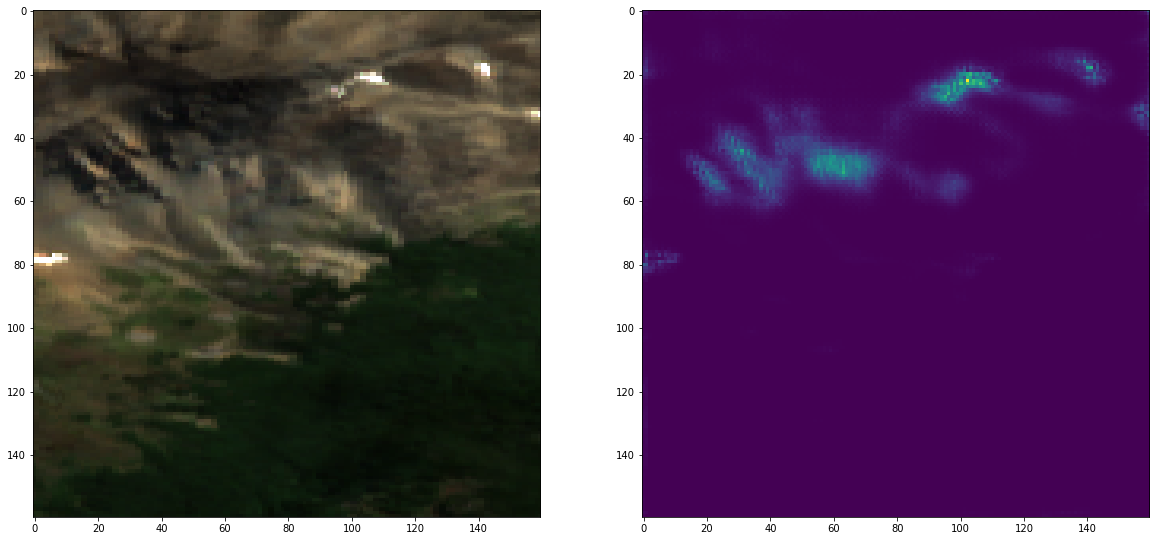

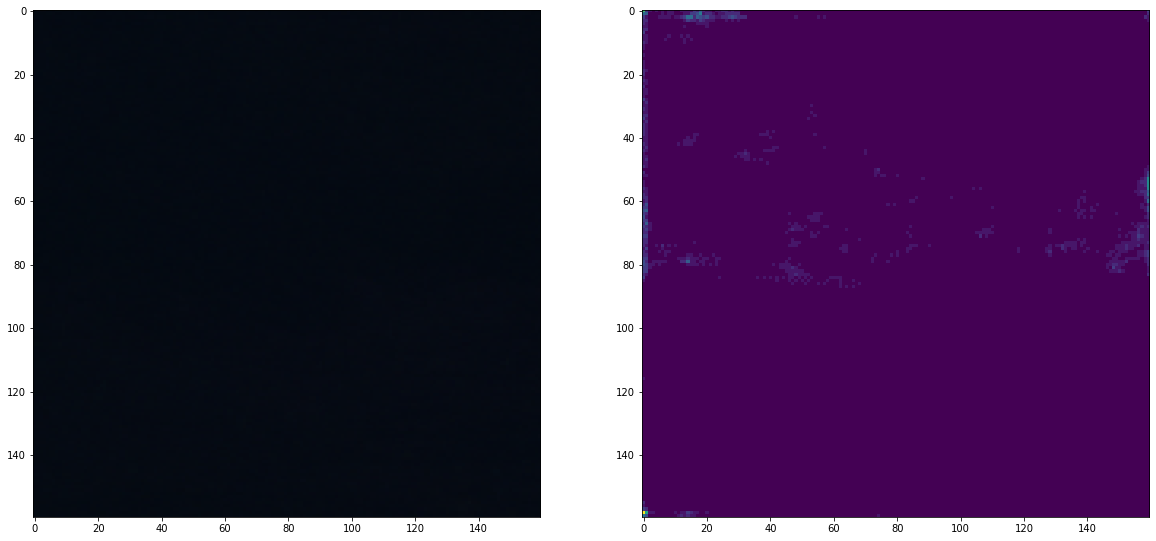

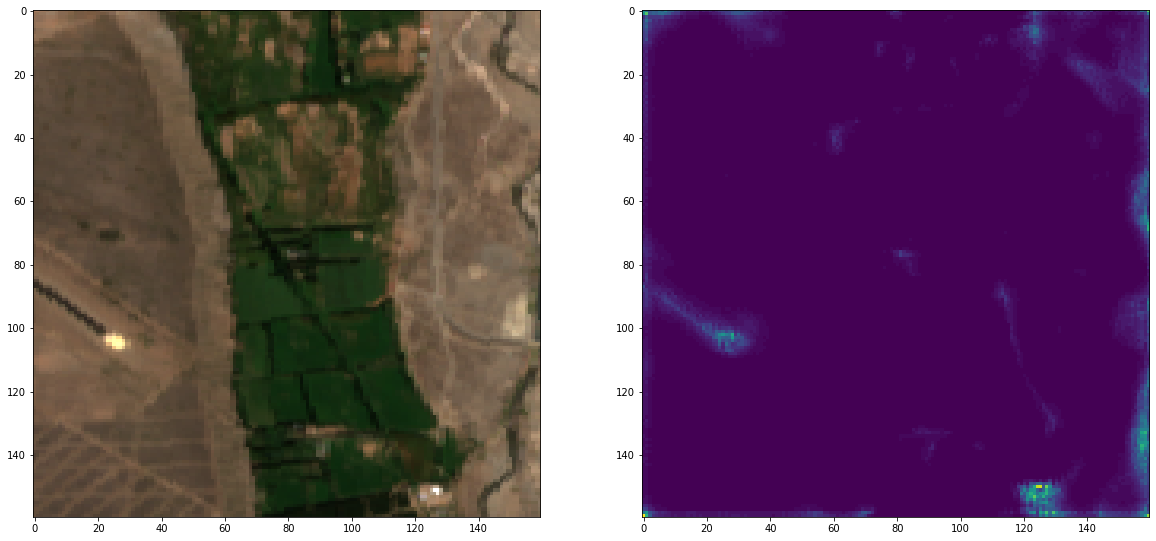

In [6]:
plot_data_results(num_samples=5, fig_size=(5, 5), predict_config=predict_config, img_ch =2,n_bands=3)